In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"


from utils import CustomDataset, GANLoss, Vgg19
from generator import AttU_Net
from discriminator import Discriminator



In [2]:
class Args:
    epoch=0
    n_epochs=200
    batchSize=1
    dataroot='../hair_swap/data/jan04_px96.npz'
    lr=0.0005
    decay_epoch=100
    size=96
    input_nc=3
    output_nc=3
    cuda=True
    n_cpu=32
    
opt = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
file = np.load(opt.dataroot)
x_1 = file['only_face']
x_2 = file['only_hair']
y = file['both']



x_con = np.concatenate((x_1,x_2), -1)

x_train, x_test, y_train, y_test = train_test_split(x_con, y, test_size=0.2, random_state=42)
x_train1 = x_train[:, :, :, 0:3]
x_train2 = x_train[:, :, :, 3:6]

x_test1 = x_test[:, :, :, 0:3]
x_test2 = x_test[:, :, :, 3:6]

In [4]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=[-10,10], translate=[0.00,0.08], scale=[0.65,1.00], shear=5, fillcolor=(255,255,255)),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=[0.05, 0.08], ratio=[0.02,0.05], p=0.5),
])

transform_train2 = transforms.Compose([
    transforms.RandomAffine(degrees=[5,10], translate=[0.10,0.25], scale=[0.80,1.20], shear=0, fillcolor=(255,255,255)),
    transforms.ToTensor(),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
])




In [5]:
lim=-1
train_set = CustomDataset(x_train1[:lim], x_train2[:lim], y_train[:lim],
                          transform_face=transform_train2, 
                          transform_hair=transform_train, 
                          transform_others=transform_test
                         )
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

test_set = CustomDataset(x_test1, x_test2, y_test, 
                         transform_face=transform_test, 
                         transform_hair=transform_test, 
                         transform_others=transform_test
                        )
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

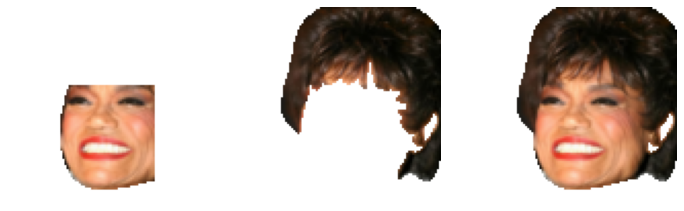

In [6]:
counter = 0
to_skip = [0, 1]

for x1, x2, y in testloader:
    
    counter+=1
    if counter in to_skip:
        continue
    
    x1 = np.transpose(x1, (0, 2, 3, 1))
    x2 = np.transpose(x2, (0, 2, 3, 1))
    y = np.transpose(y, (0, 2, 3, 1))
    f, axarr = plt.subplots(1,3, figsize=(12,6))
    
    axarr[0].imshow(x1[0])
    axarr[0].axis('off')

    axarr[1].imshow(x2[0])
    axarr[1].axis('off')

    axarr[2].imshow(y[0])
    axarr[2].axis('off')
      

    plt.show()

    
    
    break

In [7]:
generator = AttU_Net(opt.input_nc, opt.output_nc)
generator = nn.DataParallel(generator)
generator.to(device)

DataParallel(
  (module): AttU_Net(
    (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv1): conv_block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (Conv2): conv_block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
discriminator = Discriminator(opt.input_nc)

discriminator = nn.DataParallel(discriminator)
discriminator.to(device)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [9]:
perceptual_model = Vgg19()

perceptual_model = nn.DataParallel(perceptual_model)
perceptual_model.to(device)

DataParallel(
  (module): Vgg19(
    (features): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [10]:
num_epochs = 200

In [11]:
criterion_g = torch.nn.MSELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=opt.lr,
                             betas=(0.5, 0.999)
                            )


criterion_d = GANLoss().to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=opt.lr,
                             betas=(0.5, 0.999)
                            )

criterion_p = torch.nn.MSELoss()
    


In [12]:
train_total = len(train_set)
train_batches = len(trainloader)

test_total = len(test_set)
test_baches = len(testloader)


In [13]:
patience = 0    # Bad epoch counter
best_loss = 1024

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_g, factor=0.1, patience=70, verbose=True, min_lr=0.00000001,)

In [19]:
path_checkpoint = './att_unet_pivtons_for_hair_96_again.pth'

try:
    generator.load_state_dict(torch.load(path_checkpoint))
except:
    print("Generator checkpoint path not available")
    
path_checkpoint2 = './att_unet_pivtons_for_hair_discrimiator_96_again.pth'

try:
    discriminator.load_state_dict(torch.load(path_checkpoint2))    
except:
    print("Discriminator checkpoint path not available")



Generator checkpoint path not available
Discriminator checkpoint path not available


[ 1 / 200] train_loss: 9.88973   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_loss: 0.39570 -- Best loss: 0.39570 --- 320.48 seconds
----------------------------------EPOCH 0-----------------------------------------------
--------------------TRAINING DATA-----------------------


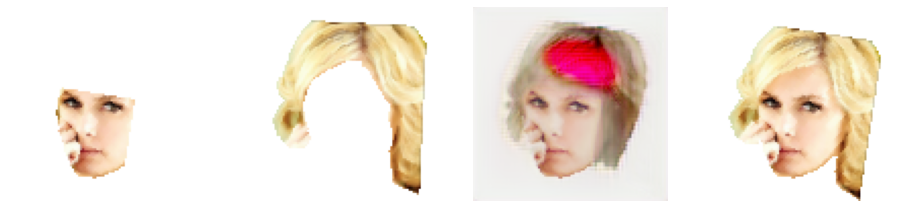

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------TRAINING DATA-----------------------
--------------------TESTING DATA-----------------------


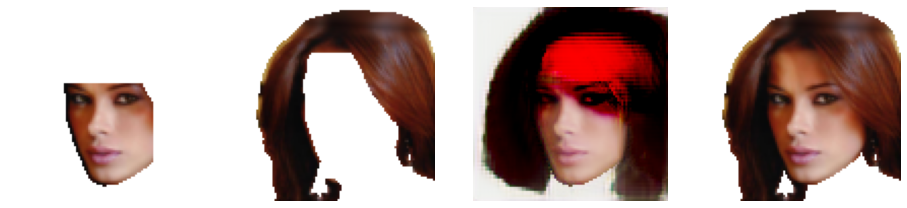

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------TESTING DATA-----------------------
--------------------MIXED DATA-----------------------


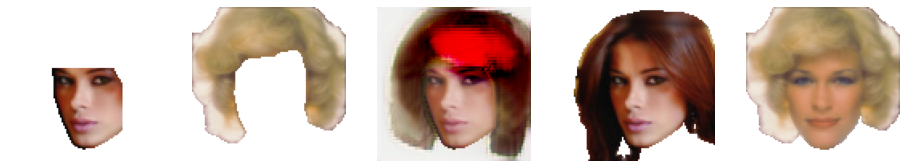

--------------------MIXED DATA-----------------------
----------------------------------EPOCH 0-----------------------------------------------
[ 2 / 200] train_loss: 7.72104   test_loss: 0.06206 -- Best loss: 0.06206 --- 314.41 seconds
[ 3 / 200] train_loss: 7.11667   test_loss: 0.07429 -- Best loss: 0.06206 --- 312.92 seconds
[ 4 / 200] train_loss: 6.79516   test_loss: 0.05067 -- Best loss: 0.05067 --- 313.60 seconds
[ 5 / 200] train_loss: 6.52310   test_loss: 0.05655 -- Best loss: 0.05067 --- 313.92 seconds
[ 6 / 200] train_loss: 6.32760   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_loss: 0.06312 -- Best loss: 0.05067 --- 313.81 seconds
----------------------------------EPOCH 5-----------------------------------------------
--------------------TRAINING DATA-----------------------


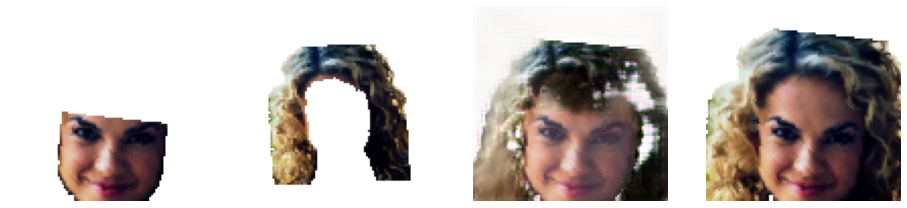

--------------------TRAINING DATA-----------------------
--------------------TESTING DATA-----------------------


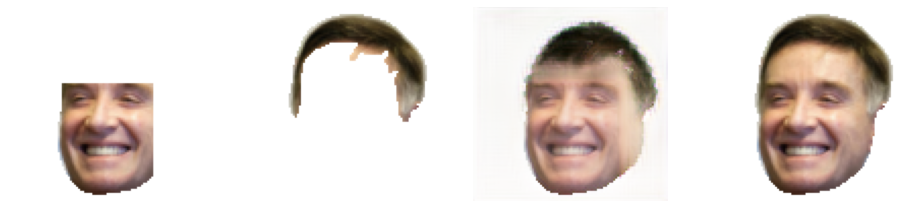

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------TESTING DATA-----------------------
--------------------MIXED DATA-----------------------


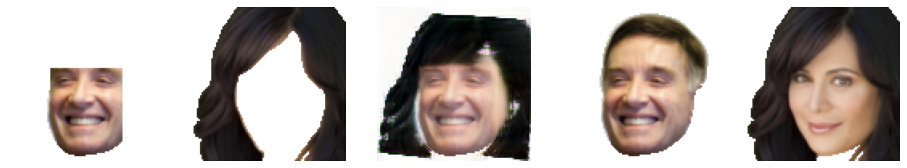

--------------------MIXED DATA-----------------------
----------------------------------EPOCH 5-----------------------------------------------
[ 7 / 200] train_loss: 6.21458   test_loss: 0.04055 -- Best loss: 0.04055 --- 312.62 seconds
[ 8 / 200] train_loss: 5.65197   test_loss: 0.02919 -- Best loss: 0.02919 --- 313.09 seconds
[ 9 / 200] train_loss: 5.59466   test_loss: 0.08271 -- Best loss: 0.02919 --- 312.46 seconds
[10 / 200] train_loss: 5.57132   test_loss: 0.04551 -- Best loss: 0.02919 --- 313.71 seconds
[11 / 200] train_loss: 5.51482   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_loss: 0.04651 -- Best loss: 0.02919 --- 313.02 seconds
----------------------------------EPOCH 10-----------------------------------------------
--------------------TRAINING DATA-----------------------


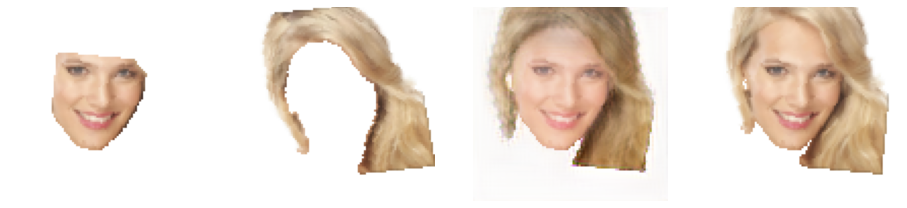

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------TRAINING DATA-----------------------
--------------------TESTING DATA-----------------------


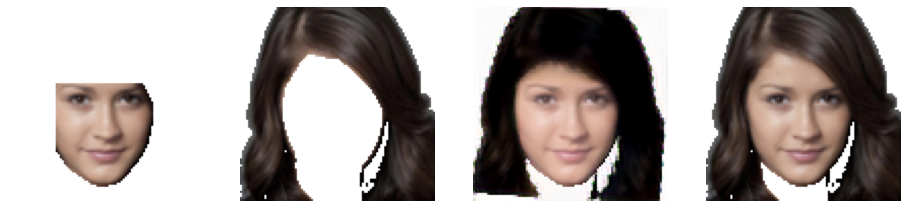

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------TESTING DATA-----------------------
--------------------MIXED DATA-----------------------


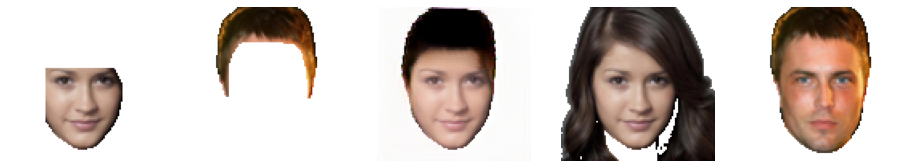

--------------------MIXED DATA-----------------------
----------------------------------EPOCH 10-----------------------------------------------
[12 / 200] train_loss: 5.42460   test_loss: 0.10266 -- Best loss: 0.02919 --- 311.84 seconds
[13 / 200] train_loss: 5.34655   test_loss: 0.03348 -- Best loss: 0.02919 --- 313.29 seconds
[14 / 200] train_loss: 5.27061   test_loss: 0.03591 -- Best loss: 0.02919 --- 324.52 seconds


KeyboardInterrupt: 

In [21]:
count = 0
for epoch in range(num_epochs):
    # Train
    
    
    generator.train()
    discriminator.train()

    train_loss = 0
    train_correct = 0

    start_time = time.time()
    for x1, x2, y in trainloader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)

        #forward
        fake = generator(x1,x2)
        
        
        #########################
        # (1) Calculate Perceptual Loss
        #########################

        fake_feature = perceptual_model(fake)
        real_feature = perceptual_model(y)

        loss_p = 0
        for i in range(5):
            loss_p += criterion_p(fake_feature[i], real_feature[i])        
        
        
        ##########################
        # (2) Update Discriminator
        ##########################
        
        #Train with fake
        optimizer_d.zero_grad()
        pred_fake = discriminator(fake)
        loss_d_fake = criterion_d(pred_fake, False)
        
        #Train with real
        pred_real = discriminator(y)
        loss_d_real = criterion_d(pred_real, True)
        
        #Average and update
        loss_d_total = (loss_d_fake + loss_d_real) * 0.5
        loss_d_total.backward(retain_graph=True)
        optimizer_d.step()
        
        
        ###########################
        # (3) Update Generator
        ###########################
        optimizer_g.zero_grad()
        
        #Get Discriminator Loss
        pred_fake = discriminator(fake)
        loss_gan = criterion_d(pred_fake, True)
        
        
        #Get Generator Loss
        loss_g = criterion_g(fake, y)
        
        loss_total = loss_gan + loss_g + loss_p
        loss_total.backward(retain_graph=True)
        optimizer_g.step()

        train_loss += loss_total.item()

    train_loss = train_loss / train_batches

    scheduler.step(1.)

    end_time = time.time()
    
    print('[%2d / %d] train_loss: %.5f  ' % (epoch+1, num_epochs , train_loss), end = ' ')
        
    generator.eval()
    
    
    ### test acc ###
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            images1, images2, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            outputs = generator(images1, images2)
            
            loss = criterion_g(outputs, labels)
            test_loss += loss.item()
            
            
        test_loss = test_loss / test_baches
        
        if(test_loss < best_loss):
            torch.save(generator.state_dict(), path_checkpoint)
            torch.save(discriminator.state_dict(), path_checkpoint2)
            best_loss = test_loss
        print('test_loss: %.5f -- Best loss: %.5f --- %.2f seconds' %(test_loss, best_loss, (end_time-start_time)))    
        
        
        
    if(epoch % 5 == 0):
        temp_out = copy.deepcopy(outputs.detach().cpu())
        print("----------------------------------EPOCH " + str(epoch) + "-----------------------------------------------")
        
        print("--------------------TRAINING DATA-----------------------")
        outputs = generator(x1,x2)
        x1 = np.transpose(x1.cpu(), (0, 2, 3, 1))
        x2 = np.transpose(x2.cpu(), (0, 2, 3, 1))
        o = np.transpose(outputs.detach().cpu(), (0, 2, 3, 1))
        y = np.transpose(y.cpu(), (0, 2, 3, 1))
        f, axarr = plt.subplots(1,4, figsize=(16,9))

        axarr[0].imshow(x1[0])
        axarr[0].axis('off')

        axarr[1].imshow(x2[0])
        axarr[1].axis('off')

        axarr[2].imshow(o[0])
        axarr[2].axis('off')


        axarr[3].imshow(y[0])
        axarr[3].axis('off')    
        plt.show()
        print("--------------------TRAINING DATA-----------------------")
        
        
        print("--------------------TESTING DATA-----------------------")
        x1 = np.transpose(images1.cpu(), (0, 2, 3, 1))
        x2 = np.transpose(images2.cpu(), (0, 2, 3, 1))
        o = np.transpose(temp_out, (0, 2, 3, 1))
        y = np.transpose(labels.cpu(), (0, 2, 3, 1))
        f, axarr = plt.subplots(1,4, figsize=(16,9))

        axarr[0].imshow(x1[0])
        axarr[0].axis('off')

        axarr[1].imshow(x2[0])
        axarr[1].axis('off')

        axarr[2].imshow(o[0])
        axarr[2].axis('off')


        axarr[3].imshow(y[0])
        axarr[3].axis('off')
        plt.show()
        print("--------------------TESTING DATA-----------------------")
        
        
        
        
        print("--------------------MIXED DATA-----------------------")
        x1 = np.transpose(images1.cpu(), (0, 2, 3, 1))
        x2 = np.transpose(images2.cpu(), (0, 2, 3, 1))
        outputs = generator(images1[0:1],images2[1:2])
        o = np.transpose(outputs.detach().cpu(), (0, 2, 3, 1))
        y = np.transpose(labels.cpu(), (0, 2, 3, 1))
        f, axarr = plt.subplots(1,5, figsize=(16,9))

        axarr[0].imshow(x1[0])
        axarr[0].axis('off')

        axarr[1].imshow(x2[1])
        axarr[1].axis('off')

        axarr[2].imshow(o[0])
        axarr[2].axis('off')


        axarr[3].imshow(y[0])
        axarr[3].axis('off')

        axarr[4].imshow(y[1])
        axarr[4].axis('off')
        plt.show()
        print("--------------------MIXED DATA-----------------------")
        


        plt.show()
        print("----------------------------------EPOCH " + str(epoch) + "-----------------------------------------------")

In [22]:
torch.save(generator.module.state_dict(), path_checkpoint)
torch.save(discriminator.state_dict(), path_checkpoint2)